In [1]:
import os
import sys
import warnings
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[1].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

from obsrv_plan.general.params import DATA_FILE_PATH, MAX_PARALLEL, WORKING_DIR

import time
import random
# import requests
import csv

from multiprocessing import Pool, Lock

SPLITS_DIR = os.path.join(WORKING_DIR, "splits")
os.makedirs(SPLITS_DIR, exist_ok=True)

LOCK = Lock()
MAX_PARALLEL = 10

In [3]:
import math

def writeSplit(lines: list[str], header: str, split: int) -> str:
	splitFilePath = os.path.join(SPLITS_DIR, f"{split}.csv")
	print(f"Writing split {split} to {splitFilePath}")	
	with open(splitFilePath, 'w+') as splitFile:
		splitFile.write(header + "\n")
		splitFile.writelines(lines)
	print("Finished writing split")
	return splitFilePath

splitCsvFiles = [os.path.join(SPLITS_DIR, f) for f in os.listdir(SPLITS_DIR)] # don't try to split if files already present
if len(splitCsvFiles) == 0:
	totalNumRows = 3_239_305 # wc -l "SDSS 3_4 Filter GDR3-result.csv"
	split = math.ceil(totalNumRows / MAX_PARALLEL)
	with open(DATA_FILE_PATH, 'r') as targetsCsv:
		isReadingHeader = True
		header: str
		curSplitLines = []
		curSplit = 0
		for lineList in csv.reader(targetsCsv):
			rawLine = ",".join(lineList) + '\n'
			if isReadingHeader:
				header = rawLine
				isReadingHeader = False
			else:
				curSplitLines.append(rawLine)

			if len(curSplitLines) == split:
				splitCsvFiles.append(writeSplit(curSplitLines, header, curSplit))
				curSplitLines.clear()
				curSplit += 1

	if len(curSplitLines) != 0:
		splitCsvFiles.append(writeSplit(curSplitLines, header, curSplit))
splitCsvFiles

['/home/ramon/uanl/thesis/Backup Data/Gaia Query Results/sdss-half/splits/0.csv',
 '/home/ramon/uanl/thesis/Backup Data/Gaia Query Results/sdss-half/splits/1.csv',
 '/home/ramon/uanl/thesis/Backup Data/Gaia Query Results/sdss-half/splits/10.csv',
 '/home/ramon/uanl/thesis/Backup Data/Gaia Query Results/sdss-half/splits/11.csv',
 '/home/ramon/uanl/thesis/Backup Data/Gaia Query Results/sdss-half/splits/12.csv',
 '/home/ramon/uanl/thesis/Backup Data/Gaia Query Results/sdss-half/splits/13.csv',
 '/home/ramon/uanl/thesis/Backup Data/Gaia Query Results/sdss-half/splits/14.csv',
 '/home/ramon/uanl/thesis/Backup Data/Gaia Query Results/sdss-half/splits/15.csv',
 '/home/ramon/uanl/thesis/Backup Data/Gaia Query Results/sdss-half/splits/2.csv',
 '/home/ramon/uanl/thesis/Backup Data/Gaia Query Results/sdss-half/splits/3.csv',
 '/home/ramon/uanl/thesis/Backup Data/Gaia Query Results/sdss-half/splits/4.csv',
 '/home/ramon/uanl/thesis/Backup Data/Gaia Query Results/sdss-half/splits/5.csv',
 '/home/ra

In [4]:
def printSync(stringPrint: str) -> None:
	with LOCK:
		print(os.getpid(), stringPrint)

class StarRecord:

	def __init__(self, gaia_source_id: str, simbad_id: str, ra: float, dec: float, type: str) -> None:
		self.gaia_source_id = gaia_source_id
		self.simbad_id = simbad_id
		self.ra = ra
		self.dec = dec
		self.type = type

	def to_dict(self) -> dict[str, str]:
		return {
			"gaia_source_id": self.gaia_source_id,
			"simbad_id": self.simbad_id,
			"ra": str(self.ra),
			"dec": str(self.dec),
			"type": self.type
		}

	def __str__(self) -> str:
		return f"gid={self.gaia_source_id}, sid={self.simbad_id}, ra={self.ra}, dec={self.dec}, type={self.type}"
	
	def __repr__(self) -> str:
		return str(self)

In [5]:
from astroquery.simbad import Simbad
from astropy.table.table import Table

customSimbad = Simbad()
customSimbad.add_votable_fields('otype', 'ids')

def querySimbad(source_ids_batch: list[str]) -> Table:
	with warnings.catch_warnings(action='ignore'):
		triesRemaining = 3
		while True:
			if triesRemaining == 0:
				return Table() # return empty table
			triesRemaining -= 1
			try:
				return customSimbad.query_objects(source_ids_batch)
			except:
				printSync(f"SIMBAD query failed. Retrying {triesRemaining} more {('times' if triesRemaining > 1 else 'time')}.")
				time.sleep(random.randint(3, 5))

def getGaiaSourceId(ids) -> str:
	for s_id in ids:
		if 'Gaia DR3' in s_id:
			return s_id.replace('Gaia DR3 ', '')

def toStarRecords(batch_results: Table) -> list[StarRecord]:
	starRecords: list[StarRecord] = []
	for i in range(len(batch_results)):
		row = batch_results[i]
		gaiaSourceId = getGaiaSourceId(row['IDS'].split('|'))
		starRecords.append(StarRecord(gaia_source_id=gaiaSourceId, simbad_id=row['MAIN_ID'], ra=row['RA'], dec=row['DEC'], type=row['OTYPE']))
	return starRecords

def processSources(starRows: csv.reader) -> list[StarRecord]:
	header = next(starRows)
	sid_idx = header.index("source_id")

	starRecords: list[StarRecord] = []
	queryBatch = []
	failedSources = 0
	for row in starRows:
		if len(row) == 0: # empty row
			continue

		queryBatch.append(f"Gaia DR3 {row[sid_idx]}")
		if len(queryBatch) == 2000:
			time.sleep(random.randint(3, 10)) # prevent spamming SIMBAD
			tableResults = querySimbad(queryBatch)
			starRecords += toStarRecords(tableResults)
			failedSources += len(queryBatch) - len(tableResults)
			queryBatch.clear()
			printSync(f"Processed {(len(starRecords) + failedSources)} sources | {failedSources} sources without match in SIMBAD.")
	tableResults = querySimbad(queryBatch)
	failedSources += len(queryBatch) - (len(tableResults) if tableResults else 0)
	printSync(f"Found {len(starRecords)} records. Failed to find data for {failedSources} GDR3 sources.")
	return starRecords

def multiProcessSources(sourcesCsvFilePath: str):
	printSync(sourcesCsvFilePath)
	with open(sourcesCsvFilePath, 'r') as file:
		starRows = csv.reader(file)
		try:
			return processSources(starRows)
		except Exception as e:
			with LOCK:
				print("EXCEPTION:", sourcesCsvFilePath, e)
			raise e

with Pool(MAX_PARALLEL) as p:
	resultLists = p.map(multiProcessSources, splitCsvFiles)

simbadStars = [item for sublist in resultLists for item in sublist]
# simbadStars

179412 /home/ramon/uanl/thesis/Backup Data/Gaia Query Results/sdss-half/splits/0.csv
179413 /home/ramon/uanl/thesis/Backup Data/Gaia Query Results/sdss-half/splits/1.csv
179414 /home/ramon/uanl/thesis/Backup Data/Gaia Query Results/sdss-half/splits/10.csv
179415 /home/ramon/uanl/thesis/Backup Data/Gaia Query Results/sdss-half/splits/11.csv
179416 /home/ramon/uanl/thesis/Backup Data/Gaia Query Results/sdss-half/splits/12.csv
179417 /home/ramon/uanl/thesis/Backup Data/Gaia Query Results/sdss-half/splits/13.csv
179418 /home/ramon/uanl/thesis/Backup Data/Gaia Query Results/sdss-half/splits/14.csv
179419 /home/ramon/uanl/thesis/Backup Data/Gaia Query Results/sdss-half/splits/15.csv
179420 /home/ramon/uanl/thesis/Backup Data/Gaia Query Results/sdss-half/splits/2.csv
179421 /home/ramon/uanl/thesis/Backup Data/Gaia Query Results/sdss-half/splits/3.csv
179412 Processed 2000 sources | 1654 sources without match in SIMBAD.
179416 Processed 2000 sources | 1675 sources without match in SIMBAD.
1794

In [6]:
categories = {}
for starRecord in simbadStars:
	starTypeList = categories.get(starRecord.type, [])
	starTypeList.append(starRecord.to_dict())
	categories[starRecord.type] = starTypeList

# categories

In [2]:
import json

categories: dict
starCategoriesJsonPath = os.path.join(WORKING_DIR, "categories.json")

if os.path.exists(starCategoriesJsonPath):
	print("Found previous categorization run file.")
	print(f"Loading saved categories from {starCategoriesJsonPath}")
	with open(starCategoriesJsonPath, 'r') as file:
		categories = json.load(file)
else:
	print(f"Saving SIMBAD categories to {starCategoriesJsonPath}")
	with open(starCategoriesJsonPath, 'w+') as file:
		json.dump(categories, file)

Found previous categorization run file.
Loading saved categories from /home/ramon/uanl/thesis/Backup Data/Gaia Query Results/sdss-half/categories.json


In [3]:
categoryCountsDict = {cat:len(records) for cat, records in categories.items()}
categoryCountsDict = {k: v for k, v in sorted(categoryCountsDict.items(), key=(lambda item: item[1]), reverse=True)}

In [4]:
categoryCounts = [(cat, count) for cat, count in categoryCountsDict.items()]
categoriesList = [cat for cat, _ in categoryCounts]
counts = [count for _, count in categoryCounts]

In [5]:
# %%script echo "skipping; no need to trim at this point"
includeCategories = ["EclBin", "EclBin_Candidate", "CataclyV*", "CataclyV*_Candidate"]
trimmedCategories = {"Misc.": 0}
for cat, count in categoryCounts:
	if count < 113 and cat not in includeCategories:
		trimmedCategories["Misc."] += count
	else:
		trimmedCategories[cat] = count

categoryCounts = [(cat, count) for cat, count in trimmedCategories.items()]
categoriesList = [cat for cat, _ in categoryCounts]
counts = [count for _, count in categoryCounts]

In [6]:
import numpy as np
np.sum(counts)

997199

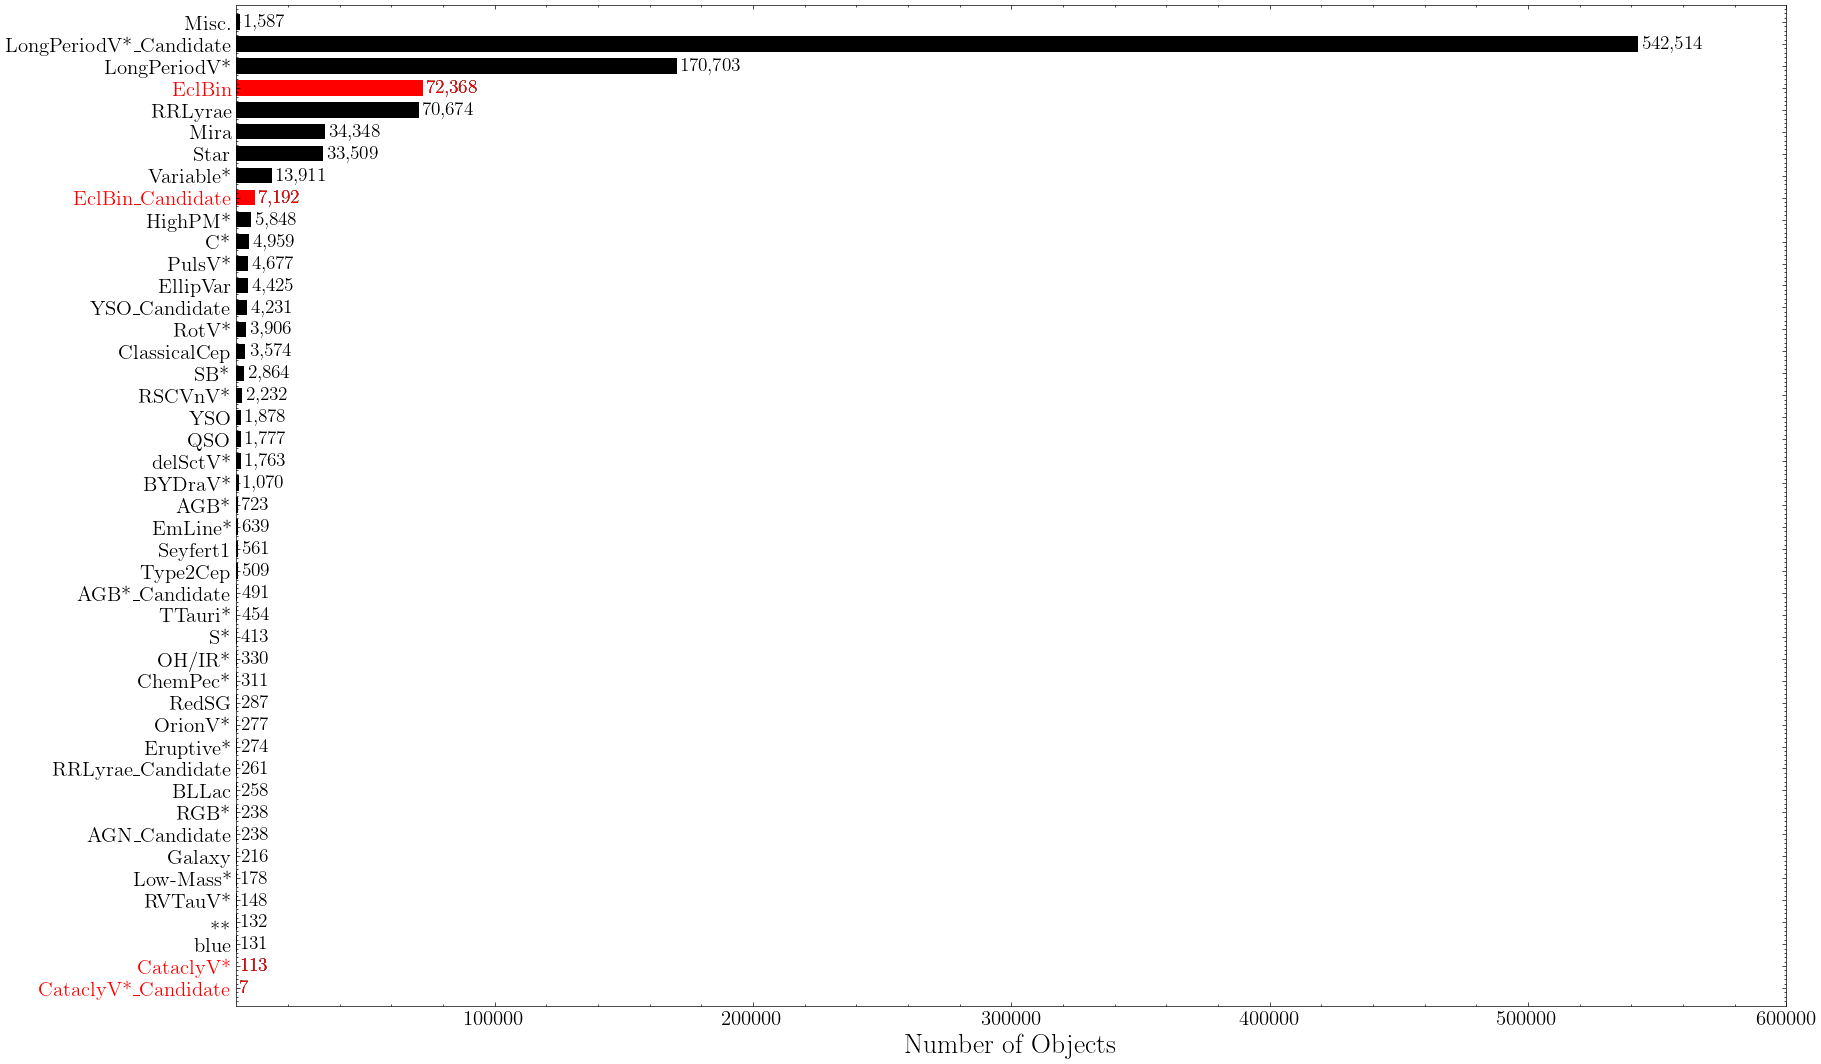

In [18]:
import matplotlib.pyplot as plt
import numpy as np

import scienceplots
plt.style.use("science")

fig, ax = plt.subplots(figsize=(20, 13))
yPos = np.arange(len(categoriesList))

hbars = ax.barh(categoriesList, counts, align='center', color="black", height=0.7)
ax.set_yticks(yPos, labels=categoriesList, fontsize=15)
ax.tick_params(axis='x', labelsize=15)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Number of Objects', fontsize=20)
ax.set_xlim(1, 600_000)
# ax.set_xlim(1, 1e7)
# ax.set_xscale('log')
# ax.set_title('GDR3 SIMBAD Categories', fontsize=16)
ax.bar_label(hbars, labels=[f"{c:,}" for c in counts], padding=3, fontsize=14)

# highlight desired categories
desiredCategories_yPos = []
desiredCategories_counts = []
for c in includeCategories:
    c_idx = categoriesList.index(c)
    desiredCategories_yPos.append(yPos[c_idx])
    desiredCategories_counts.append(counts[c_idx])
hbars = ax.barh(includeCategories, desiredCategories_counts, align='center', color="r", height=0.7)
ax.bar_label(hbars, labels=[f"{c:,}" for c in desiredCategories_counts], color='r', padding=3, fontsize=14)
for tick in ax.get_yticklabels():
    if tick.get_text() in includeCategories:
        tick.set_color('r')

ax.set_ymargin(0.01)
plt.show()